# Classify Cards Using PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm #for image classification

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

C:\Users\Loricson\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
print('Python Version', sys.version)
print('PyTorch Version', torch.__version__)
print('Torchvision Version', torchvision.__version__)
print('Numpy Version', np.__version__)
print('Pandas Version', pd.__version__)

Python Version 3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]
PyTorch Version 2.3.0+cu118
Torchvision Version 0.18.0+cpu
Numpy Version 1.24.2
Pandas Version 2.1.3


## Load dataset 

In [4]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):  
        self.data = ImageFolder(data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

# __init__ tells the class what to do when created, transform = apply to each item in the dataset in the same fashion (e.g. resize all images)

In [7]:
dataset = PlayingCardDataset(
    data_dir='train'
)

In [8]:
len(dataset)

7624

In [10]:
dataset[500]

(<PIL.Image.Image image mode=RGB size=224x224>, 3)

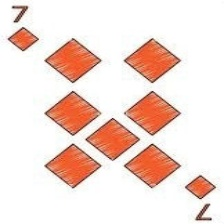

In [11]:
image, label = dataset[5000]
image

In [12]:
print(label)

34


In [13]:
data_dir='train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [15]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = 'train'
dataset = PlayingCardDataset(data_dir, transform)

In [16]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [17]:
# iterate over dataset
for image, label in dataset:
    break

## Dataloaders
- batching dataset - automatically handle processing and reading of these images 

In [19]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle=True)

#batch size = number of examples to be used each iteration
# shuffle =  every new example is loaded, shuffle will be done (needed on training data only)

In [24]:
for images, labels in dataloader:
    break

In [25]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [26]:
labels

tensor([43, 20,  8,  0, 52, 28, 43, 20, 18,  4, 47, 37, 47, 13, 51, 29, 27,  2,
        32, 26, 28, 13, 45, 52, 29, 40, 37, 50, 47,  5, 29, 20])

## Create Model 

In [31]:
# class SimpleCardClassifier(nn.Module):
#     def __init(self, num_classes=53): #define all parts of the model
#         super(SimpleCardClassifier, self).__init__()
#         self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
#         self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
#         enet_out_size = 1280
#         #make a classifier
#         self.classifier = nn.Linear(enet_out_size, num_classes)
        
#     def forward(self, x): # connect these parts and return output
#         x = self.features(x)
#         output = self.classifier(x)
#         return output

class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


In [33]:
model = SimpleCardClassifer(num_classes=53)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

C:\Users\Loricson\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Loricson\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [34]:
print(model)

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, ker

In [36]:
model(images)

tensor([[ 0.1058, -0.3193,  0.0425,  ...,  0.5958, -0.0727, -0.4510],
        [-0.1775, -0.6466, -0.0320,  ...,  0.0550,  0.3756, -0.2609],
        [-0.1057,  0.2122,  0.2756,  ...,  0.0997, -0.2021, -0.3909],
        ...,
        [-0.2543,  0.3404, -0.1791,  ..., -0.0064,  0.3686,  0.6194],
        [ 0.2508,  0.0180, -0.4016,  ...,  0.2012, -0.2893, -0.1445],
        [-0.1051,  0.0136, -0.2624,  ...,  0.0478,  0.3268, -0.3394]],
       grad_fn=<AddmmBackward0>)

In [38]:
example_output = model(images)
example_output.shape

torch.Size([32, 53])

## Model Training

In [39]:
# Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
#testing out loss function
criterion(example_output, labels)

tensor(4.0130, grad_fn=<NllLossBackward0>)

### Setup Datasets

In [51]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = 'train'
valid_folder = 'valid'
test_folder = 'test'

train_dataset = PlayingCardDataset(train_folder, transform = transform)
val_dataset = PlayingCardDataset(valid_folder, transform = transform)
test_dataset = PlayingCardDataset(test_folder, transform = transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [56]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.6529019205417612, Validation loss: 0.46987374413688227


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5846923083723654, Validation loss: 0.2238093321053487


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.36409682720305414, Validation loss: 0.22581237852573394


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.2522132158482688, Validation loss: 0.238532680835364


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.19935911237912063, Validation loss: 0.18215660958919885


## Visualize losses 

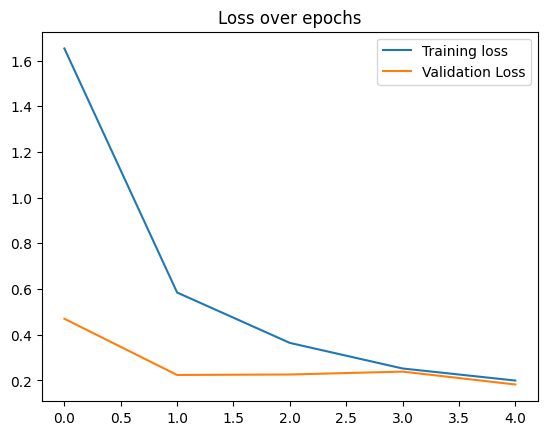

In [57]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Result Evaluation 

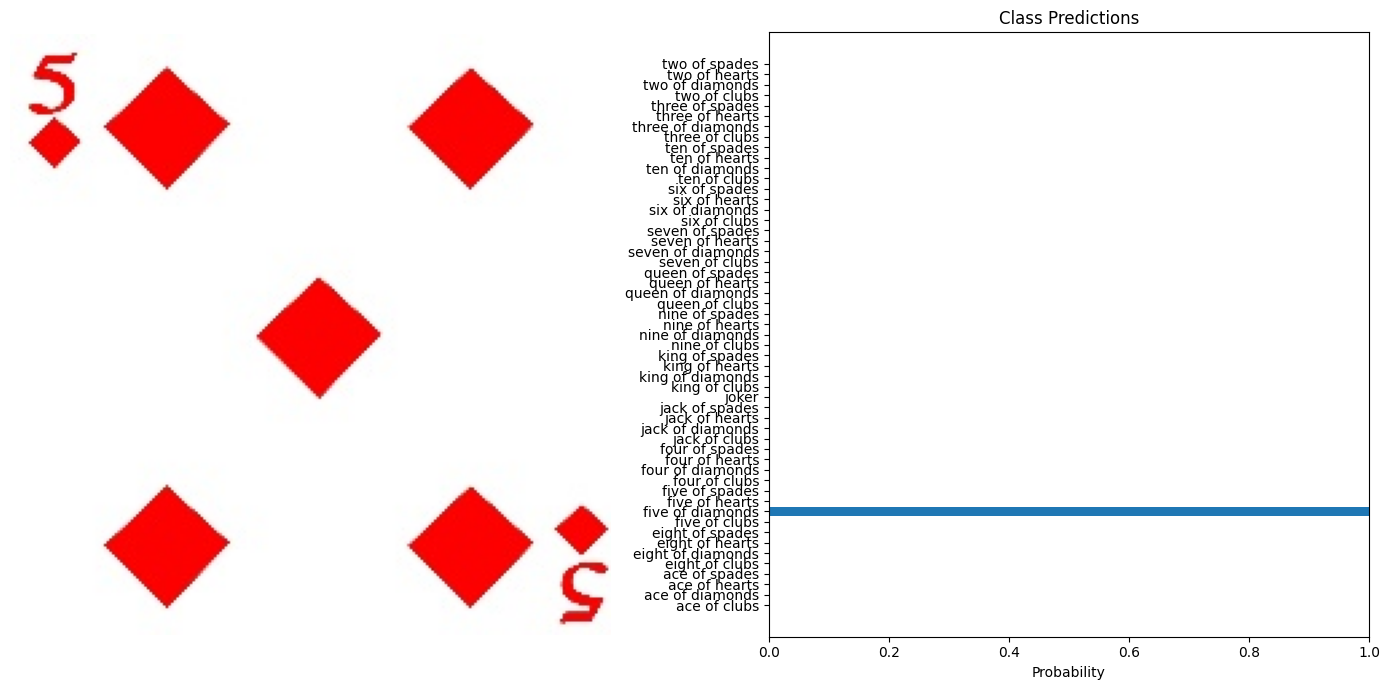

In [58]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#load and preprocess the images
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

#Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

#Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    #Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    #Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

#Example usage
test_image = "test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

#Assuming dataset.classess gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

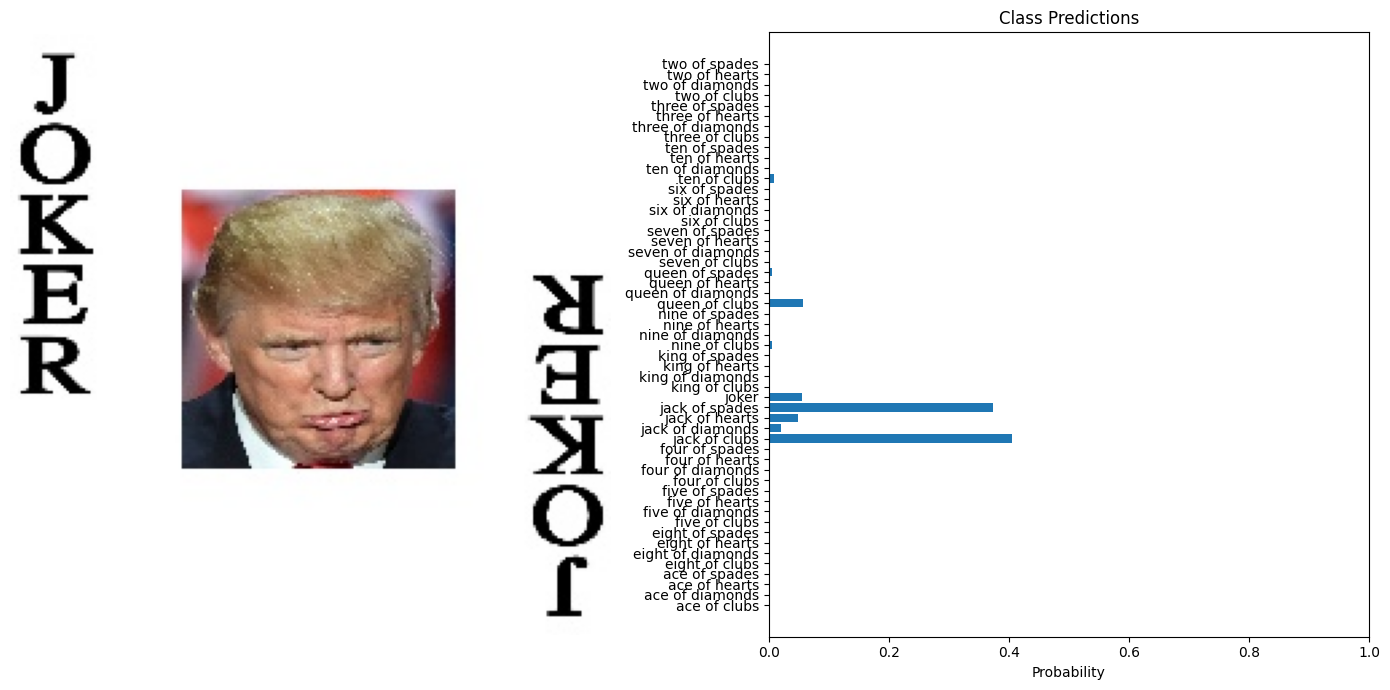

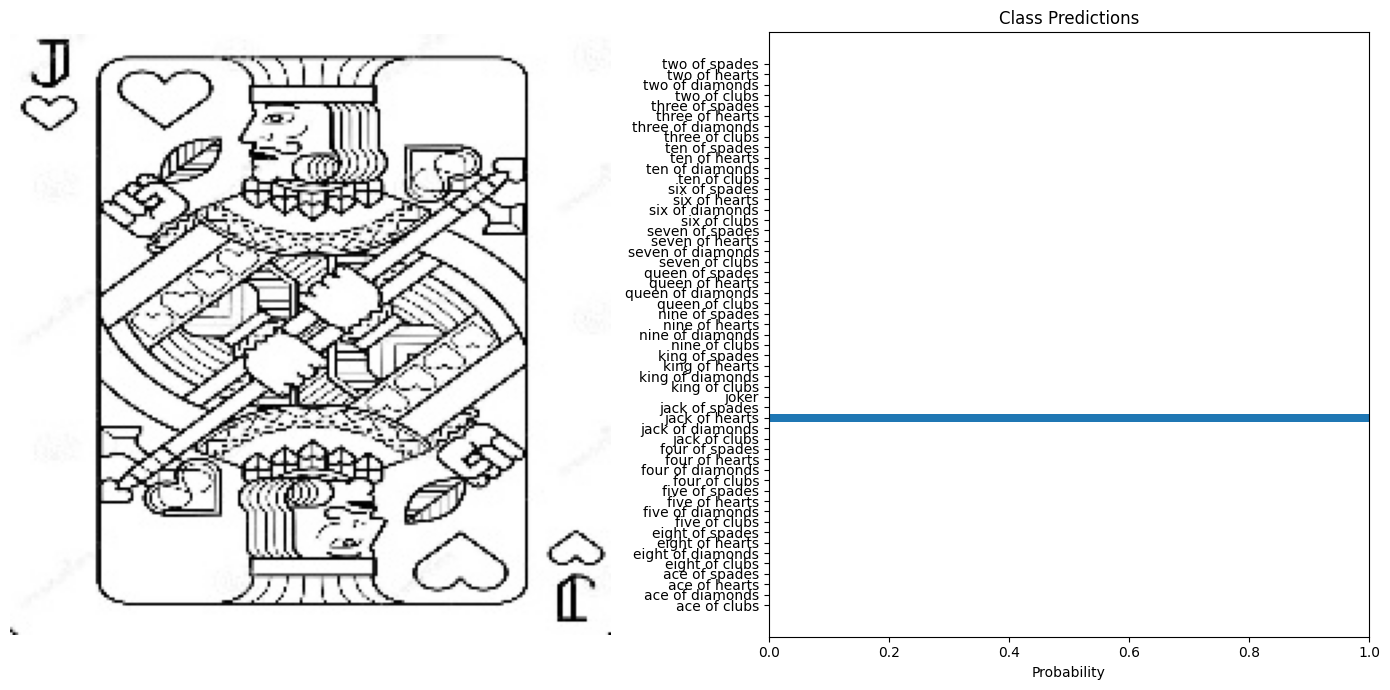

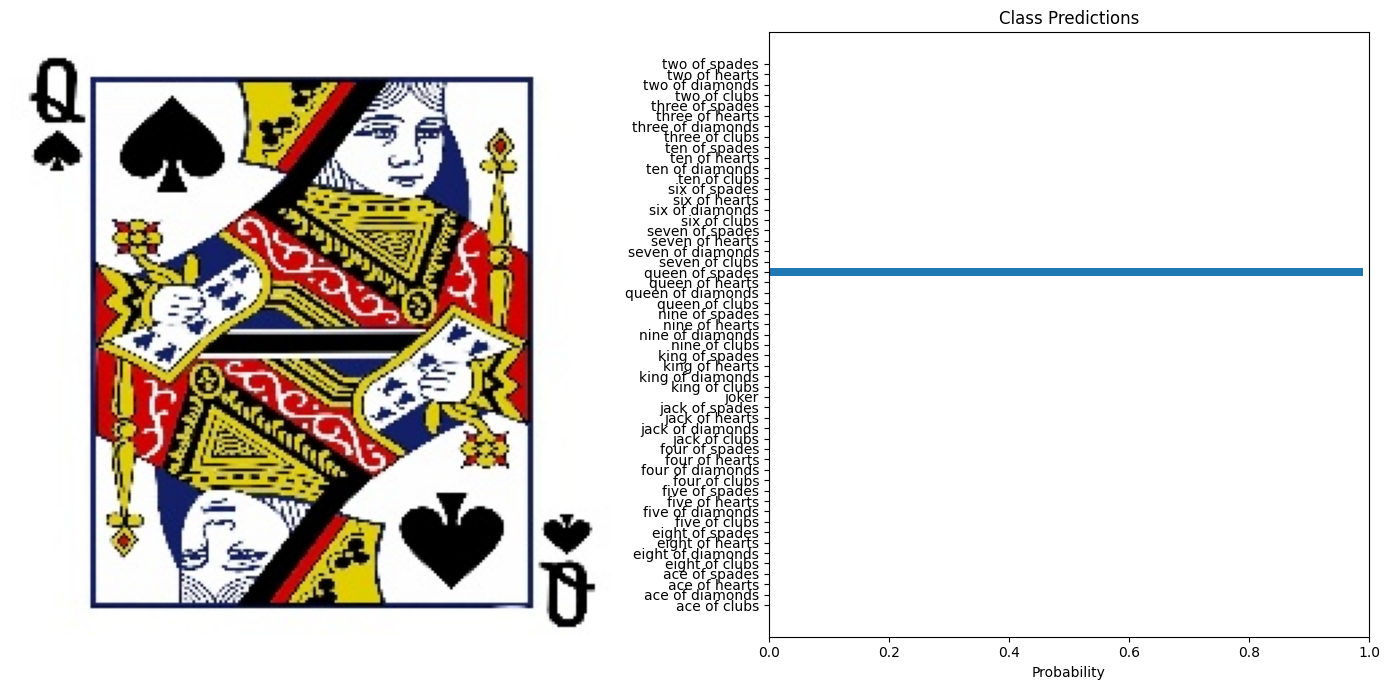

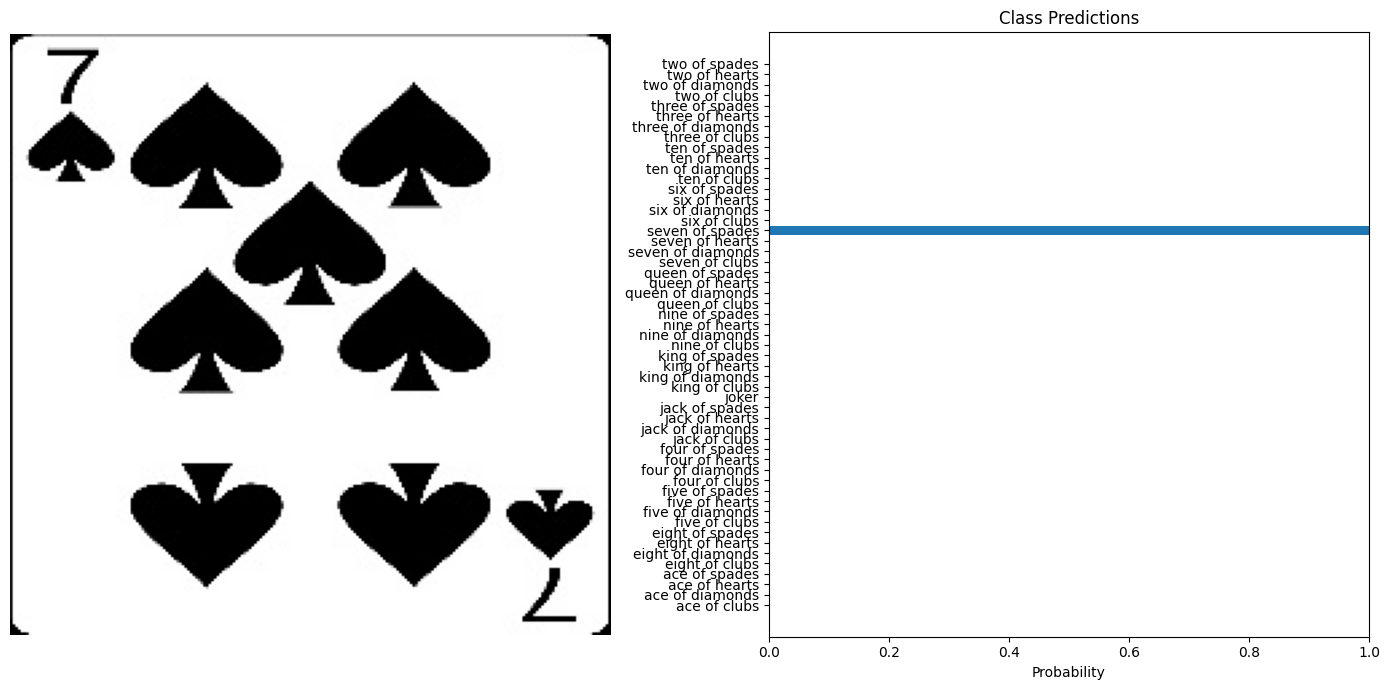

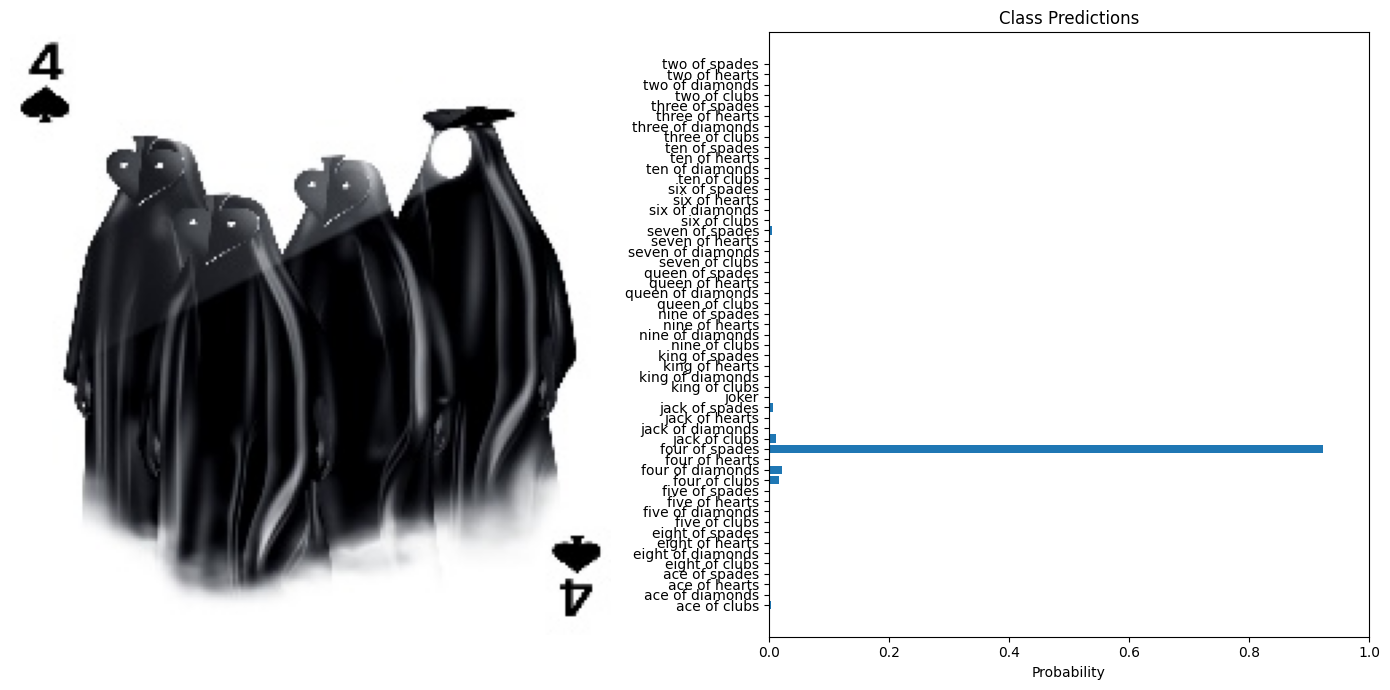

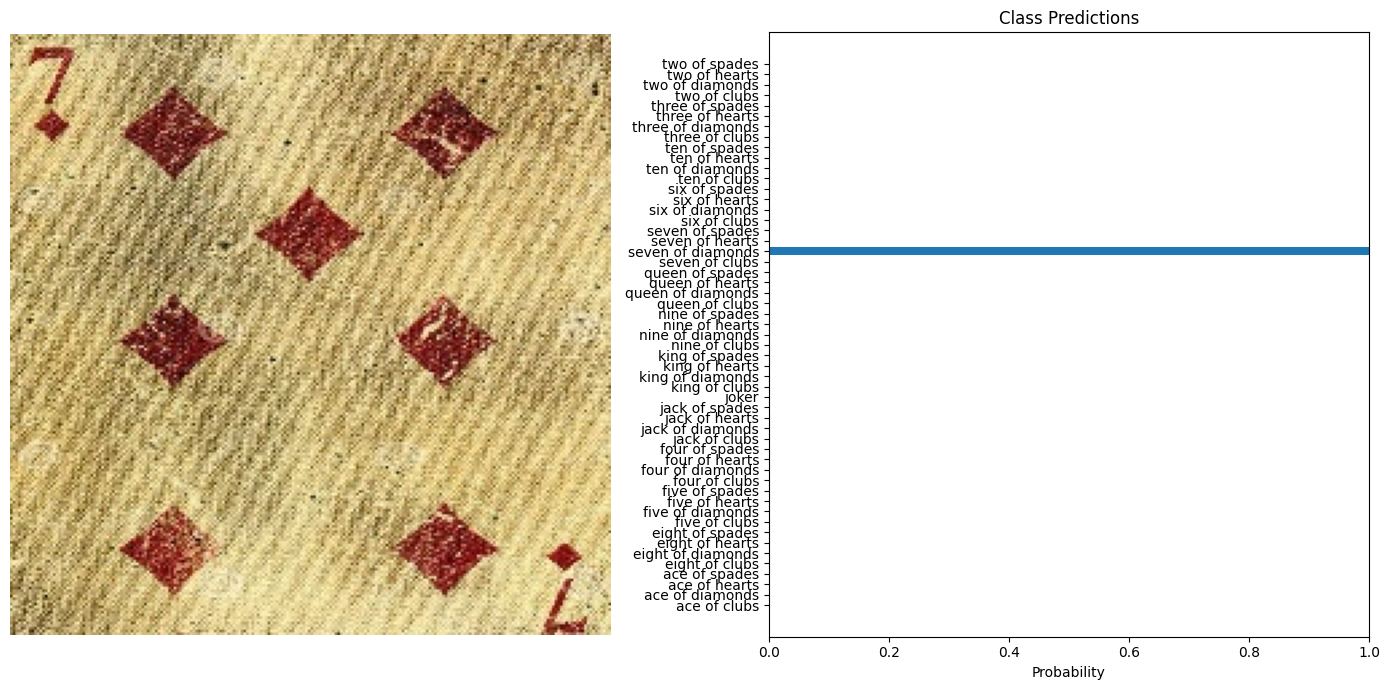

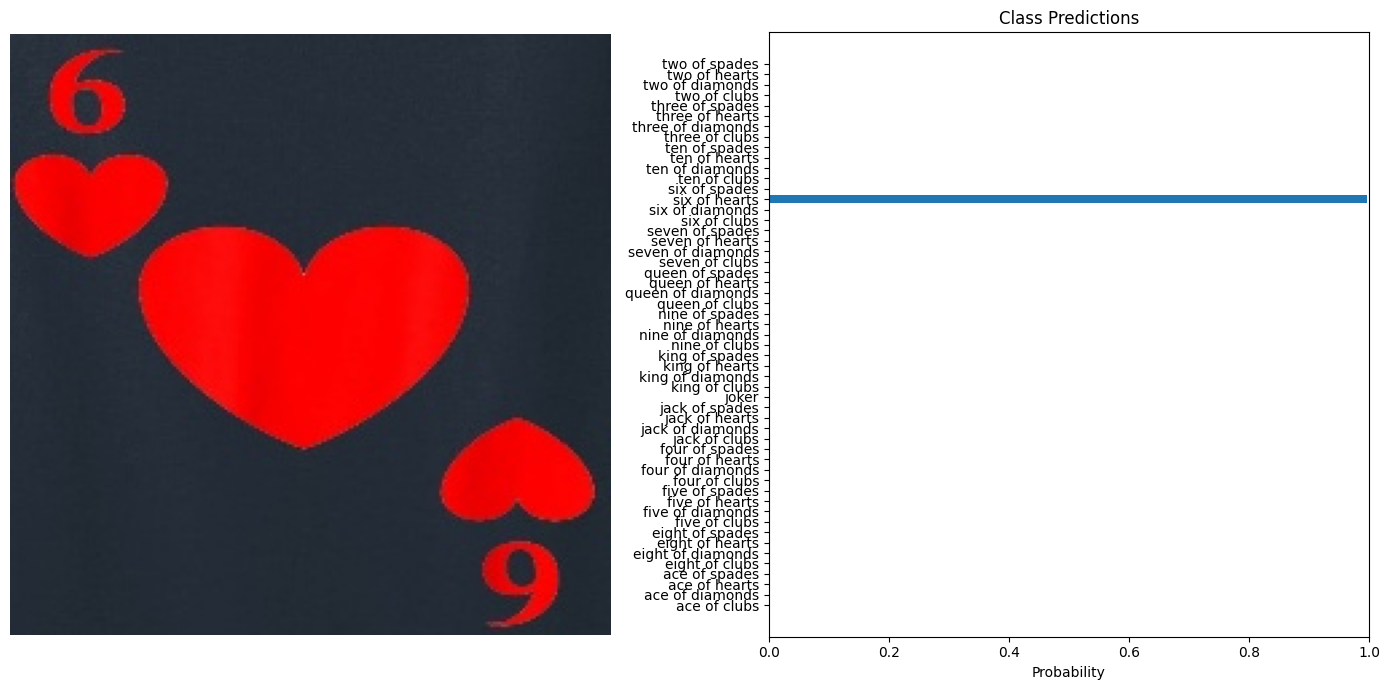

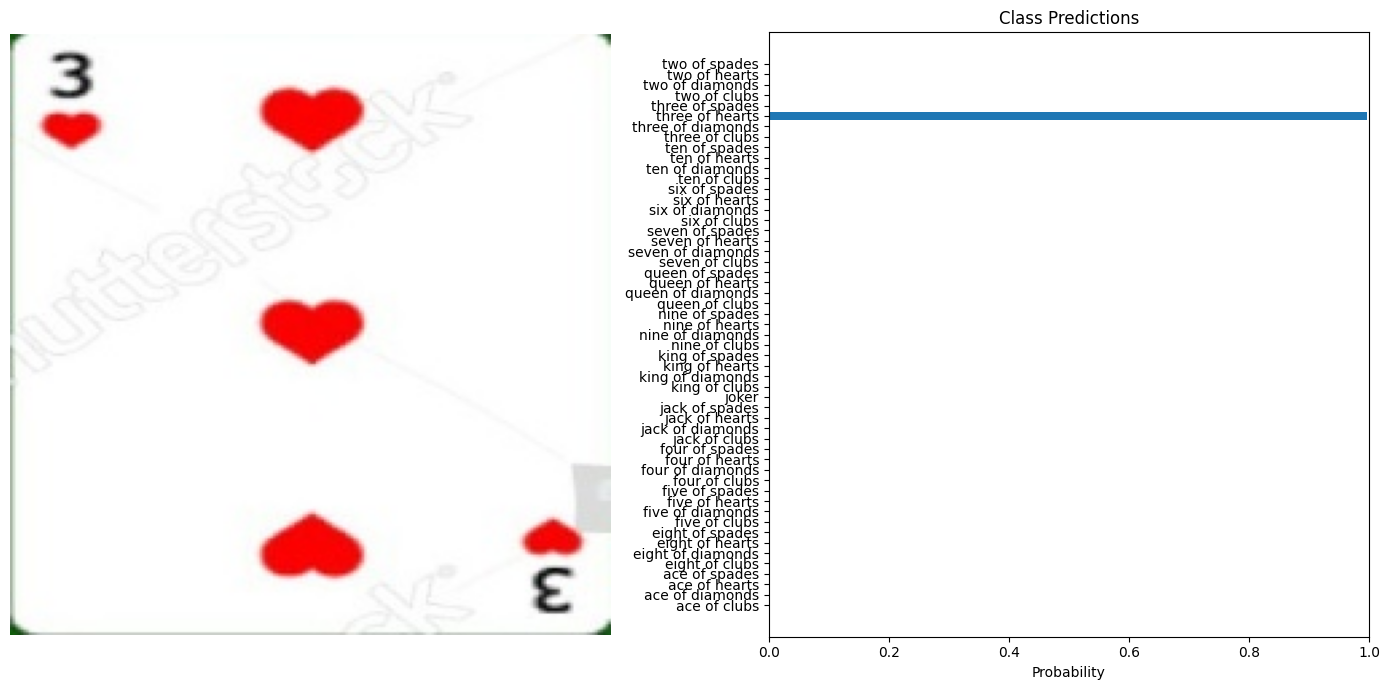

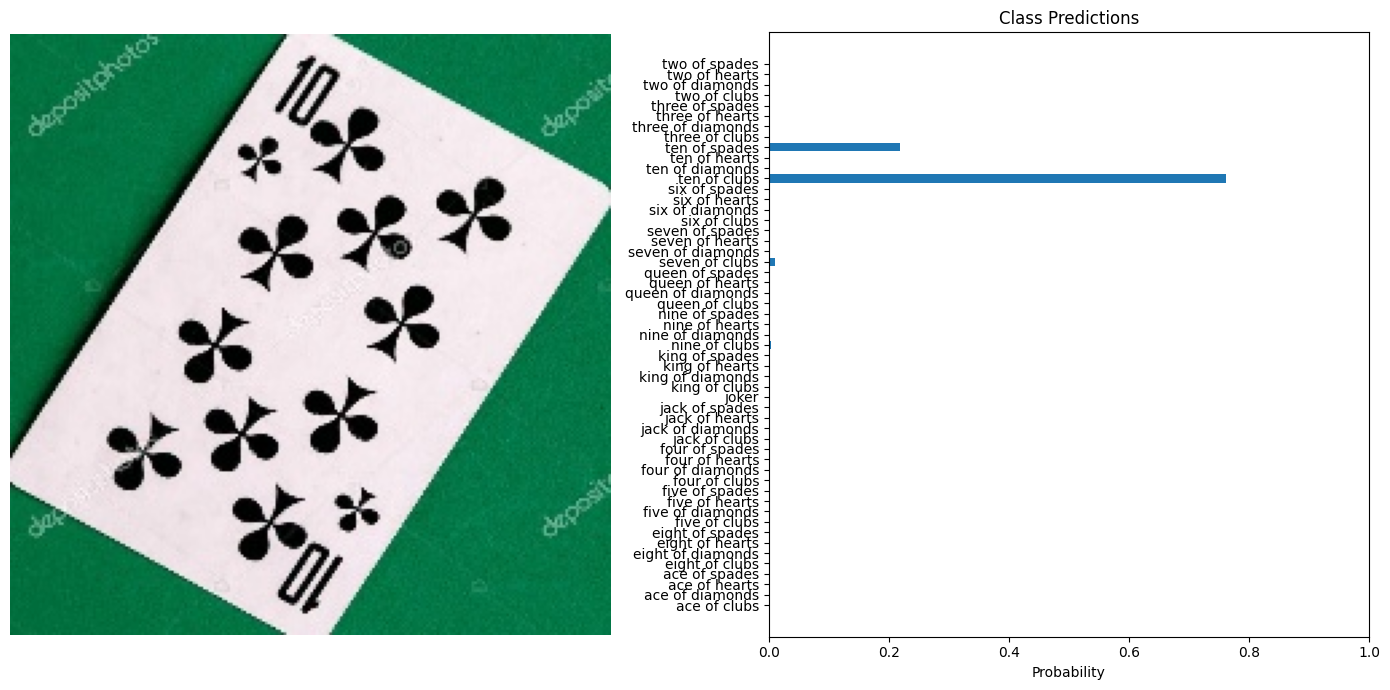

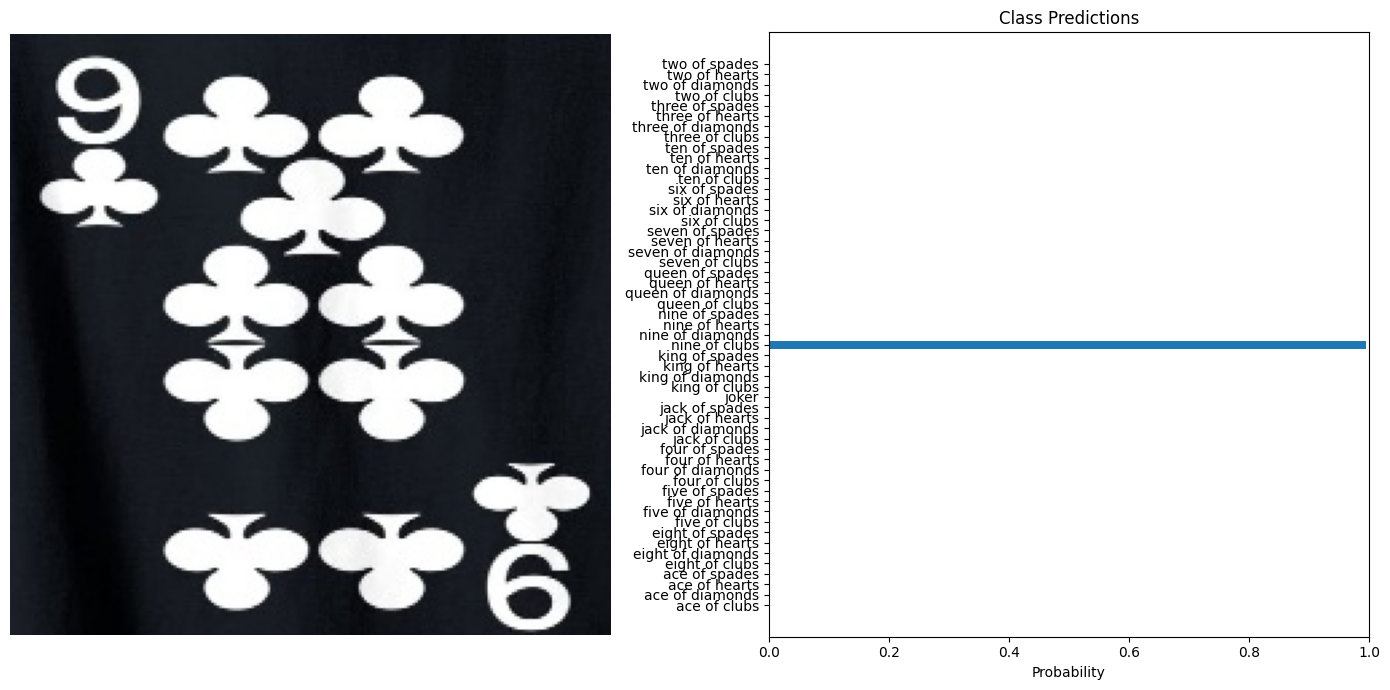

In [62]:
from glob import glob
test_images = glob('test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    #Assume dataset.classess gives the class names
    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)